In [ ]:
# Preparing the new 2022 ward boundaries and associated lookups for the London 
# Borough of Lewisham, based on the boundaries published by the Boundary 
# Commission for the 2023 review of wards.
#
# We export the following lookup tables:
# - a mapping of OAs and LSOAs to 2022 Wards for Lewisham
#
# These new boundaries will likely remain unchanged before they come into effect
# by May 2022. However the lookups will likely need to be revised once the new 
# 2021 Census boundaries have been published.

In [ ]:
# For spatial indexing -- advice is to do this before geopandas
!apt install libspatialindex-dev
!pip install --upgrade rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (455 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

In [ ]:
# Dependencies
!pip install geopandas

     |████████████████████████████████| 1.0 MB 7.8 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.3 MB 40.0 MB/s 


In [ ]:
import os

import pandas as pd
import geopandas as gpd

from google.colab import drive
import google.colab.files as files

Data
==


GDrive mount
--

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Used as root folder.
project_dir = '/content/gdrive/MyDrive/WardProfiles'

# Boundary files folders.
oa_dir = f"{project_dir}/boundaries/oa"

# Output folders
wards_dir = f"{project_dir}/boundaries/2022_wards"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"

In [ ]:
# Clean. !! Use with caution !!
# !rm -rf "{ward_dir}"

In [ ]:
# !ls -lh "{wards_dir}"

In [ ]:
!mkdir -p "{wards_dir}"
!mkdir -p "{ward_lookups_dir}"

Ward boundary download
--


In [ ]:
# All proposed ward boundary changes under review
# Source: 
# https://boundarycommissionforengland.independent.gov.uk/data-and-resources/
!wget 'https://boundarycommissionforengland.independent.gov.uk/wp-content/uploads/2021/03/Wards_for_2023_review_SHP.zip' \
  -O "{wards_dir}/Wards_for_2023_review_SHP.zip"

--2021-11-01 10:47:14--  https://boundarycommissionforengland.independent.gov.uk/wp-content/uploads/2021/03/Wards_for_2023_review_SHP.zip
Resolving boundarycommissionforengland.independent.gov.uk (boundarycommissionforengland.independent.gov.uk)... 52.85.135.105, 52.85.135.48, 52.85.135.33, ...
Connecting to boundarycommissionforengland.independent.gov.uk (boundarycommissionforengland.independent.gov.uk)|52.85.135.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56571503 (54M) [application/zip]
Saving to: ‘/content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/Wards_for_2023_review_SHP.zip’

/content/gdrive/MyD 100%[===================>]  53.95M  39.8MB/s    in 1.4s    

2021-11-01 10:47:15 (39.8 MB/s) - ‘/content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/Wards_for_2023_review_SHP.zip’ saved [56571503/56571503]



In [ ]:
!ls -lh "{wards_dir}"

-rw------- 1 root root 54M Jul  9 02:57 /content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/Wards_for_2023_review_SHP.zip


Load ward boundaries
--

In [ ]:
all_wards = gpd.read_file(f"{wards_dir}/Wards_for_2023_review_SHP.zip")
all_wards.columns

Index(['gid', 'name', 'electorate', 'ons_code', 'area', 'popdensity',
       'regionid', 'geometry'],
      dtype='object')

In [ ]:
all_wards.head()

,gid,name,electorate,ons_code,area,popdensity,regionid,geometry
0,6987.0,Kingswood Ward,1825,E05013191,28.186,65.0,9,"MULTIPOLYGON (((376490.446 191595.005, 376490...."
1,6985.0,Wotton-under-Edge Ward,5671,E05013199,38.167,149.0,9,"MULTIPOLYGON (((377105.700 191485.497, 377108...."
2,1.0,Rushden Pemberton West,9303,E05013234,3.060,3040.0,2,"POLYGON ((494210.303 266517.399, 494204.498 26..."
3,2.0,Rushden South,11195,E05013235,15.206,736.0,2,"POLYGON ((500321.896 264597.199, 500298.398 26..."
4,3.0,Brickhill and Queensway,8845,E05013213,5.325,1661.0,2,"POLYGON ((485161.200 268978.295, 485164.597 26..."


In [ ]:
all_wards.groupby('regionid').regionid.count()

regionid
1     973
2     771
3     655
4     842
5     765
6     470
7    1310
8     342
9     896
Name: regionid, dtype: int64

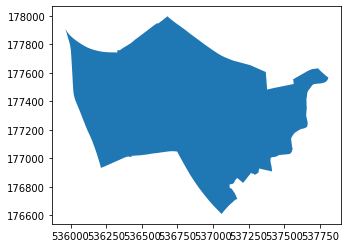

In [ ]:
all_wards[all_wards.name=='Deptford'].plot()

Load OA11 centroids
--

In [ ]:
oac = gpd.read_file(f"{oa_dir}/lbl_oa11_centroids.gpkg")
lsoac = gpd.read_file(f"{oa_dir}/lbl_lsoa11_centroids.gpkg")
msoac = gpd.read_file(f"{oa_dir}/lbl_msoa11_centroids.gpkg")

In [ ]:
oac.columns

Index(['OBJECTID', 'OA11CD', 'geometry'], dtype='object')

Spatial join & export as lookup tables
--

In [ ]:
# Select & standardise column names for this spatial join
all_wards_sjview = all_wards[['name', 'ons_code', 'geometry']].\
  rename(columns={
    'name': 'WD22NM_proposed',
    'ons_code': 'WD22CD_proposed',
  })
all_wards_sjview.head()

,WD22NM_proposed,WD22CD_proposed,geometry
0,Kingswood Ward,E05013191,"MULTIPOLYGON (((376490.446 191595.005, 376490...."
1,Wotton-under-Edge Ward,E05013199,"MULTIPOLYGON (((377105.700 191485.497, 377108...."
2,Rushden Pemberton West,E05013234,"POLYGON ((494210.303 266517.399, 494204.498 26..."
3,Rushden South,E05013235,"POLYGON ((500321.896 264597.199, 500298.398 26..."
4,Brickhill and Queensway,E05013213,"POLYGON ((485161.200 268978.295, 485164.597 26..."


In [ ]:
# point-in-polygon join of OAs
lbl_oa_wards = gpd.sjoin(oac[['OA11CD', 'geometry']], 
                         all_wards_sjview, 
                         how="inner", op="within").\
                         drop(columns=['geometry', 'index_right'])
# Save as lookup tables for future use
lbl_oa_wards.to_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv", index=False)

print(len(lbl_oa_wards))
lbl_oa_wards.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


887


,OA11CD,WD22NM_proposed,WD22CD_proposed
0,E00016403,Evelyn,E05013721
2,E00016442,Evelyn,E05013721
111,E00016407,Evelyn,E05013721
114,E00016404,Evelyn,E05013721
119,E00016402,Evelyn,E05013721


In [ ]:
# point-in-polygon join of LSOAs
lbl_lsoa_wards = gpd.sjoin(lsoac[['LSOA11CD', 'geometry']], 
                         all_wards_sjview, 
                         how="inner", op="within").\
                         drop(columns=['geometry', 'index_right'])
# Save as lookup tables for future use
lbl_lsoa_wards.to_csv(f"{ward_lookups_dir}/lbl_lsoa11_wd22_proposed.csv", index=False)

print(len(lbl_lsoa_wards))
lbl_lsoa_wards.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


169


,LSOA11CD,WD22NM_proposed,WD22CD_proposed
0,E01003316,Perry Vale,E05013729
2,E01003314,Perry Vale,E05013729
3,E01003312,Perry Vale,E05013729
4,E01003313,Perry Vale,E05013729
5,E01003310,Perry Vale,E05013729


In [ ]:
# point-in-polygon join of MSOAs
lbl_msoa_wards = gpd.sjoin(msoac[['MSOA11CD', 'geometry']], 
                         all_wards_sjview, 
                         how="inner", op="within").\
                         drop(columns=['geometry', 'index_right'])
# Save as lookup tables for future use
lbl_msoa_wards.to_csv(f"{ward_lookups_dir}/lbl_msoa11_wd22_proposed.csv", index=False)

print(len(lbl_msoa_wards))
lbl_msoa_wards.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if self.run_code(code, result):


36


,MSOA11CD,WD22NM_proposed,WD22CD_proposed
0,E02006784,Downham,E05013720
1,E02006783,Downham,E05013720
2,E02000666,Ladywell,E05013725
7,E02000663,Ladywell,E05013725
3,E02000667,Crofton Park,E05013718


In [26]:
# Export as {code: name} lookup table of all LBL wards
lbl_oa_wards[['WD22CD_proposed', 'WD22NM_proposed']].drop_duplicates().sort_values(by='WD22CD_proposed').to_csv(f"{ward_lookups_dir}/lbl_wd22_proposed.csv", index=False)

Boundary data prep & export
---


In [ ]:
# Get the subset of proposed wards that are in Lewisham
lbl_wd22_proposed = all_wards[all_wards.ons_code.isin(lbl_oa_wards.WD22CD_proposed.unique())].copy()

# Duplicate some of the provided columns under their standard names
lbl_wd22_proposed['WD22CD_proposed'] = lbl_wd22_proposed.ons_code
lbl_wd22_proposed['WD22NM_proposed'] = lbl_wd22_proposed.name

print(len(lbl_wd22_proposed))
lbl_wd22_proposed.head()

19


,gid,name,electorate,ons_code,area,popdensity,regionid,geometry,WD22CD_proposed,WD22NM_proposed
1011,1114.0,Forest Hill,10511,E05013722,1.828,5750.0,3,"POLYGON ((535143.197 174119.298, 535221.500 17...",E05013722,Forest Hill
1012,1115.0,Rushey Green,10755,E05013730,1.994,5394.0,3,"POLYGON ((537864.820 174454.090, 537879.010 17...",E05013730,Rushey Green
1013,1116.0,Hither Green,12093,E05013724,2.148,5630.0,3,"POLYGON ((538423.400 174952.200, 538427.750 17...",E05013724,Hither Green
1017,1118.0,Lee Green,9804,E05013726,1.793,5468.0,3,"POLYGON ((538823.950 175235.050, 538826.700 17...",E05013726,Lee Green
1018,1119.0,Ladywell,10386,E05013725,2.037,5099.0,3,"POLYGON ((537634.310 176201.060, 537644.780 17...",E05013725,Ladywell


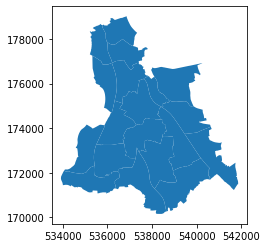

In [ ]:
lbl_wd22_proposed.plot()

In [ ]:
# In total we export three file formats
for gd, name in zip([lbl_wd22_proposed], 
                      ['lbl_wd22_proposed']):
  print(f"{name}...")

  gd.to_file(filename=f"{wards_dir}/{name}.geojson", driver='GeoJSON')
  gd.to_file(filename=f"{wards_dir}/{name}.gpkg", driver='GPKG')

  # This does not work, contrary to the documentation -- 
  # it creates a directory of that name, rather than a .zip file
  #gd.to_file(filename=f"{wards_dir}/{name}.zip", driver='ESRI Shapefile')
  
  # Instead we write the shapefile to a subdirectory, so we can compress it later
  os.makedirs(f"{wards_dir}/{name}_shp/",exist_ok=True)
  gd.to_file(filename=f"{wards_dir}/{name}_shp/{name}.shp", driver='ESRI Shapefile')

lbl_wd22_proposed...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  app.launch_new_instance()


In [ ]:
# Compress the shapefile folders, for easier download
!zip -r "{wards_dir}/lbl_wd22_proposed_shp.zip" "{ward_dir}/lbl_wd22_proposed_shp"

  adding: content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed_shp/ (stored 0%)
  adding: content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed_shp/lbl_wd22_proposed.shp (deflated 58%)
  adding: content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed_shp/lbl_wd22_proposed.shx (deflated 27%)
  adding: content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed_shp/lbl_wd22_proposed.dbf (deflated 90%)
  adding: content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed_shp/lbl_wd22_proposed.cpg (stored 0%)
  adding: content/gdrive/MyDrive/WardProfiles/boundaries/2022_wards/lbl_wd22_proposed_shp/lbl_wd22_proposed.prj (deflated 34%)


Directory content
--

In [ ]:
!ls -lh '{wards_dir}' 

total 55M
-rw------- 1 root root 5.2K Nov  1 14:55 lbl_lsoa11_wd22_proposed.csv
-rw------- 1 root root 1.2K Nov  1 14:55 lbl_msoa11_wd22_proposed.csv
-rw------- 1 root root  28K Nov  1 14:55 lbl_oa11_wd22_proposed.csv
-rw------- 1 root root 537K Nov  1 14:53 lbl_wd22_proposed.geojson
-rw------- 1 root root 292K Nov  1 14:53 lbl_wd22_proposed.gpkg
drwx------ 2 root root 4.0K Nov  1 14:53 lbl_wd22_proposed_shp
-rw------- 1 root root  78K Nov  1 14:54 lbl_wd22_proposed_shp.zip
-rw------- 1 root root  54M Jul  9 02:57 Wards_for_2023_review_SHP.zip


In [ ]:
!ls -lh '{ward_lookups_dir}' 

total 35K
-rw------- 1 root root 5.2K Nov  2 14:12 lbl_lsoa11_wd22_proposed.csv
-rw------- 1 root root 1.2K Nov  2 14:12 lbl_msoa11_wd22_proposed.csv
-rw------- 1 root root  28K Nov  2 14:11 lbl_oa11_wd22_proposed.csv
